In [22]:
# TODO
# Add note of sat cyc when sarin mode expands as a 'notes' column to mid_cyc_dates

This notebook pre-processes altimetry data sets to construct a cohensive multi-mission CryoSat-2 to ICESat-2 (2010 to present) time series.

Written 2023-05-10 by W. Sauthoff (sauthoff@mines.edu)

# Set up computing environment

This notebook requires a ~32 GB server instance. There is one commented out cell that is an optional visualization that requires a larger ~64 GB server instance.

In [23]:
# Install dependencies not pre-installed
%pip install openpyxl --quiet

Note: you may need to restart the kernel to use updated packages.


In [24]:
# Install dependencies not pre-installed
%pip install ipympl --quiet

Note: you may need to restart the kernel to use updated packages.


In [25]:
# Import libraries
import datetime
import earthaccess
import geopandas as gpd
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
import pandas as pd
from pyproj import CRS, Transformer
from scipy.ndimage import zoom
import xarray as xr
from shapely.geometry import MultiPolygon, Point, Polygon

# Magic functions
%matplotlib widget

# Define data and output directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    # Notebook creates many output plots for QC'ing data that were stored outside the GitHub repo
    OUTPUT_DIR = '/home/jovyan/1_evolving_lakes/output/0_preprocess_data'

# Define utility functions
def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    x, y = ll2ps(lon, lat)
    """
    if not (-180 <= lon <= 180 and -90 <= lat <= 90):
        raise ValueError("Invalid coordinates: longitude must be between -180 and 180, latitude between -90 and 90")

    try:
        crs_ll = CRS("EPSG:4326")
        crs_xy = CRS("EPSG:3031")
        ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
        x, y = ll_to_xy.transform(lon, lat)
        return x, y
    except Exception as e:
        raise ValueError(f"Error transforming coordinates: {e}")

def transform_geometry(geometry):
    """
    Transform the geometry of a GeoDataFrame row from lon/lat to polar stereographic.
    Handles Points, Polygons, and MultiPolygons.
    """
    if geometry.geom_type == 'Polygon':
        exterior = [(x, y) for x, y in zip(*geometry.exterior.coords.xy)]
        transformed_exterior = [ll2ps(lon, lat) for lon, lat in exterior]
        new_polygon = Polygon(transformed_exterior)
        return new_polygon
    elif geometry.geom_type == 'Point':
        x, y = ll2ps(*geometry.coords[0])
        return Point(x, y)
    elif geometry.geom_type == 'MultiPolygon':
        new_polygons = []
        for polygon in geometry.geoms:
            exterior = [(x, y) for x, y in zip(*polygon.exterior.coords.xy)]
            transformed_exterior = [ll2ps(lon, lat) for lon, lat in exterior]
            new_polygons.append(Polygon(transformed_exterior))
        return MultiPolygon(new_polygons)
    else:
        # Add support for other geometry types as needed
        raise ValueError(f"Unsupported geometry type: {geometry.geom_type}")

# Import datasets

## Import previously identified subglacial lake stationary outlines

In [26]:
# Import stationary subglacial lake outlines
# stationary_lakes_gdf = gpd.read_file(os.path.join(os.getcwd(), 'output/lake_outlines/stationary_outlines/stationary_outlines_gdf.geojson'))

## Import the ATL14 DEM

In [27]:
# Log into NASA Earthdata to search for datasets
earthaccess.login()

In [28]:
# Find ICESat-2 ATL14 data granules
results = earthaccess.search_data(
    short_name='ATL14',
    version='004',
    cloud_hosted=True,
    bounding_box=(1, -89, -1, -89)  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
)

In [29]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

In [30]:
files

[<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL14/004/ATL14_A3_0324_100m_004_04.nc>,
 <File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL14/004/ATL14_A2_0324_100m_004_04.nc>,
 <File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL14/004/ATL14_A1_0324_100m_004_04.nc>,
 <File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL14/004/ATL14_A4_0324_100m_004_04.nc>]

In [31]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ATL14_A1 = xr.open_dataset(files[3])
ATL14_A2 = xr.open_dataset(files[1])
ATL14_A3 = xr.open_dataset(files[0])
ATL14_A4 = xr.open_dataset(files[2])

In [32]:
# Specify the variables to keep
variables_to_keep = ['x', 'y', 'h']

# List of xarray datasets
datasets = [ATL14_A1, ATL14_A2, ATL14_A3, ATL14_A4]

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Apply the function to each dataset
ATL14_A1, ATL14_A2, ATL14_A3, ATL14_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [33]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL14_A12 = xr.concat([ATL14_A2.isel(x=slice(0,-1)), ATL14_A1], dim="x")

In [34]:
# Delete quadrants no longer needed
del ATL14_A1, ATL14_A2

In [35]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL14_A34 = xr.concat([ATL14_A3.isel(x=slice(0,-1)), ATL14_A4], dim='x')

In [36]:
# Delete quadrants no longer needed
del ATL14_A3, ATL14_A4

In [37]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL14 = xr.concat([ATL14_A34.isel(y=slice(0,-1)), ATL14_A12], dim='y')

In [38]:
# Delete intermediary files no longer needed
del ATL14_A12, ATL14_A34

In [39]:
ATL14

<xarray.Dataset> Size: 18GB
Dimensions:  (y: 81201, x: 54601)
Coordinates:
  * x        (x) float64 437kB -2.67e+06 -2.67e+06 ... 2.79e+06 2.79e+06
  * y        (y) float64 650kB -1.39e+06 -1.39e+06 ... 2.27e+06 2.27e+06
Data variables:
    h        (y, x) float32 18GB nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/51)
    GDAL_AREA_OR_POINT:                 Area
    Conventions:                        CF-1.7
    short_name:                         ATL14
    level:                              L3B
    title:                              SET_BY_META
    description:                        This data set (ATL14) contains season...
    ...                                 ...
    processing_level:                   3B
    references:                         http://nsidc.org/data/icesat2/data.html
    project:                            ICESat-2 > Ice, Cloud, and land Eleva...
    instrument:                         ATLAS > Advanced Topographic Laser Al...
    platform:                           ICESat-2 > Ice, Cloud, and land Eleva...
    source:                             Spacecraft

## Import CryoSat-2 SARIn gridded DEM and dh data

In [40]:
# Import Smith and others, 2017, Cryosphere method CryoSat-2 (CS2) SARIn DEM data 
# https://doi.org/10.5194/tc-11-451-2017
# (closed source data aquired from co-author Ben Smith)
CS2_Smith2017_DEM = xr.open_dataset(
    DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_z0_2016.0.nc')

# View dataset metadata
CS2_Smith2017_DEM

<xarray.Dataset> Size: 3GB
Dimensions:    (x: 10901, y: 8901)
Coordinates:
  * x          (x) float64 87kB -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
  * y          (y) float64 71kB -2.185e+06 -2.184e+06 ... 2.264e+06 2.265e+06
Data variables:
    FAC        (y, x) float64 776MB ...
    SMB_a      (y, x) float64 776MB ...
    cell_area  (y, x) float64 776MB ...
    z0         (y, x) float64 776MB ...

In [41]:
# Contstruct ice-surface DEM using z0, surface mass balance (SMB), and firn air content (FAC)
# The DEM (z0) is corrected for SMB_a and FAC (i.e., they are substracted from z0) 
# To get the ice-surface elevation, we add SMB_a+FAC  
CS2_Smith2017_DEM = CS2_Smith2017_DEM.assign(DEM = CS2_Smith2017_DEM['z0'] + CS2_Smith2017_DEM['SMB_a'] + CS2_Smith2017_DEM['FAC'])
CS2_Smith2017_DEM

<xarray.Dataset> Size: 4GB
Dimensions:    (x: 10901, y: 8901)
Coordinates:
  * x          (x) float64 87kB -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
  * y          (y) float64 71kB -2.185e+06 -2.184e+06 ... 2.264e+06 2.265e+06
Data variables:
    FAC        (y, x) float64 776MB ...
    SMB_a      (y, x) float64 776MB ...
    cell_area  (y, x) float64 776MB ...
    z0         (y, x) float64 776MB ...
    DEM        (y, x) float64 776MB nan nan nan nan nan ... nan nan nan nan nan

In [42]:
# # Plot DEM to ensure things look right
# CS2_Smith2017_DEM['DEM'][:,:].plot()

In [51]:
# Import Smith and others, 2017, Cryosphere method CryoSat-2 SARIn delta height data 
# (closed source data aquired from co-author Ben Smith)
CS2_Smith2017 = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2021.5.nc')
CS2_Smith2017

<xarray.Dataset> Size: 18GB
Dimensions:      (y: 4451, x: 5451, time: 45)
Coordinates:
  * y            (y) float64 36kB -2.185e+06 -2.184e+06 ... 2.264e+06 2.265e+06
  * x            (x) float64 44kB -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
  * time         (time) float64 360B 2.01e+03 2.011e+03 ... 2.021e+03 2.022e+03
Data variables:
    mask         (y, x) float64 194MB ...
    delta_h      (time, y, x) float64 9GB ...
    count        (time, y, x) float64 9GB ...
    spatial_ref  int64 8B ...
Attributes:
    fileName:                mos_2010.5_2021.5.h5
    shortName:               CS2-Smith-2017
    identifier_product_DOI:  doi:10.5194/tc-11-451-2017

In [49]:
# Rename data variable to match ICESat-2 ATL15 data product
CS2_Smith2017 = CS2_Smith2017.rename({'count': 'data_count'})

In [57]:
CS2_Smith2017.time

<xarray.DataArray 'time' (time: 45)> Size: 360B
array([2010.5 , 2010.75, 2011.  , 2011.25, 2011.5 , 2011.75, 2012.  , 2012.25,
       2012.5 , 2012.75, 2013.  , 2013.25, 2013.5 , 2013.75, 2014.  , 2014.25,
       2014.5 , 2014.75, 2015.  , 2015.25, 2015.5 , 2015.75, 2016.  , 2016.25,
       2016.5 , 2016.75, 2017.  , 2017.25, 2017.5 , 2017.75, 2018.  , 2018.25,
       2018.5 , 2018.75, 2019.  , 2019.25, 2019.5 , 2019.75, 2020.  , 2020.25,
       2020.5 , 2020.75, 2021.  , 2021.25, 2021.5 ])
Coordinates:
  * time     (time) float64 360B 2.01e+03 2.011e+03 ... 2.021e+03 2.022e+03

In [58]:
# Create lists to store data
cyc_dates = []

# Change time to match ICESat-2 time format
for idx in range(len(CS2_Smith2017['time'])):
    cyc_date = datetime.datetime(int(CS2_Smith2017['time'].values[idx]), 1, 1) \
        + datetime.timedelta(days = (CS2_Smith2017['time'].values[idx] % 1) * 365.25)
    cyc_date_np_dt = np.datetime64(cyc_date)  # Convert to numpy.datetime64 format
    cyc_dates += [cyc_date_np_dt]
    
CS2_Smith2017_newtime = CS2_Smith2017.assign_coords(time=cyc_dates)

# Add a 'description' attribute to the 'time' data variable
CS2_Smith2017_newtime.coords['time'].attrs['description'] = 'Time for each node'

# Delete unneeded list and data set
del cyc_dates
del CS2_Smith2017

CS2_Smith2017_newtime['time']

/tmp/ipykernel_1283/2710764128.py:11: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  CS2_Smith2017_newtime = CS2_Smith2017.assign_coords(time=cyc_dates)


<xarray.DataArray 'time' (time: 45)> Size: 360B
array(['2010-07-02T15:00:00.000000000', '2010-10-01T22:30:00.000000000',
       '2011-01-01T00:00:00.000000000', '2011-04-02T07:30:00.000000000',
       '2011-07-02T15:00:00.000000000', '2011-10-01T22:30:00.000000000',
       '2012-01-01T00:00:00.000000000', '2012-04-01T07:30:00.000000000',
       '2012-07-01T15:00:00.000000000', '2012-09-30T22:30:00.000000000',
       '2013-01-01T00:00:00.000000000', '2013-04-02T07:30:00.000000000',
       '2013-07-02T15:00:00.000000000', '2013-10-01T22:30:00.000000000',
       '2014-01-01T00:00:00.000000000', '2014-04-02T07:30:00.000000000',
       '2014-07-02T15:00:00.000000000', '2014-10-01T22:30:00.000000000',
       '2015-01-01T00:00:00.000000000', '2015-04-02T07:30:00.000000000',
       '2015-07-02T15:00:00.000000000', '2015-10-01T22:30:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-04-01T07:30:00.000000000',
       '2016-07-01T15:00:00.000000000', '2016-09-30T22:30:00.000000000',
       '2017-01-01T00:00:00.000000000', '2017-04-02T07:30:00.000000000',
       '2017-07-02T15:00:00.000000000', '2017-10-01T22:30:00.000000000',
       '2018-01-01T00:00:00.000000000', '2018-04-02T07:30:00.000000000',
       '2018-07-02T15:00:00.000000000', '2018-10-01T22:30:00.000000000',
       '2019-01-01T00:00:00.000000000', '2019-04-02T07:30:00.000000000',
       '2019-07-02T15:00:00.000000000', '2019-10-01T22:30:00.000000000',
       '2020-01-01T00:00:00.000000000', '2020-04-01T07:30:00.000000000',
       '2020-07-01T15:00:00.000000000', '2020-09-30T22:30:00.000000000',
       '2021-01-01T00:00:00.000000000', '2021-04-02T07:30:00.000000000',
       '2021-07-02T15:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 360B 2010-07-02T15:00:00 ... 2021-07-02T15...
Attributes:
    description:  Time for each node

In [59]:
# Remove time slices that occur during the ICESat-2 era that will not be used to conserve memory when loaded in data analysis
# Subset the dataset for a specific time range
start_date = np.datetime64('2010-07-02T15:00:00.000000000')

# # end_date does not one quarter of overlapping data with ICESat-2 time series
# # for use when CryoSat-2 and ICESat-2 are merged and analysed as one merged data set
# end_date = np.datetime64('2018-10-01T22:30:00.000000000')

# end_date includes one quarter of overlapping data with ICESat-2 time series
# to allow for cyc-to-cyc differencing to remove datum from dh
# when CryoSat-2 and ICESat-2 are analyzed separately
end_date = np.datetime64('2019-01-01T00:00:00.000000000')  

CS2_Smith2017_subset = CS2_Smith2017_newtime.sel(time=slice(start_date, end_date))

# Delete unneeded old data set
del CS2_Smith2017_newtime

CS2_Smith2017_subset['time']

<xarray.DataArray 'time' (time: 35)> Size: 280B
array(['2010-07-02T15:00:00.000000000', '2010-10-01T22:30:00.000000000',
       '2011-01-01T00:00:00.000000000', '2011-04-02T07:30:00.000000000',
       '2011-07-02T15:00:00.000000000', '2011-10-01T22:30:00.000000000',
       '2012-01-01T00:00:00.000000000', '2012-04-01T07:30:00.000000000',
       '2012-07-01T15:00:00.000000000', '2012-09-30T22:30:00.000000000',
       '2013-01-01T00:00:00.000000000', '2013-04-02T07:30:00.000000000',
       '2013-07-02T15:00:00.000000000', '2013-10-01T22:30:00.000000000',
       '2014-01-01T00:00:00.000000000', '2014-04-02T07:30:00.000000000',
       '2014-07-02T15:00:00.000000000', '2014-10-01T22:30:00.000000000',
       '2015-01-01T00:00:00.000000000', '2015-04-02T07:30:00.000000000',
       '2015-07-02T15:00:00.000000000', '2015-10-01T22:30:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-04-01T07:30:00.000000000',
       '2016-07-01T15:00:00.000000000', '2016-09-30T22:30:00.000000000',
       '2017-01-01T00:00:00.000000000', '2017-04-02T07:30:00.000000000',
       '2017-07-02T15:00:00.000000000', '2017-10-01T22:30:00.000000000',
       '2018-01-01T00:00:00.000000000', '2018-04-02T07:30:00.000000000',
       '2018-07-02T15:00:00.000000000', '2018-10-01T22:30:00.000000000',
       '2019-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 280B 2010-07-02T15:00:00 ... 2019-01-01
Attributes:
    description:  Time for each node

## Import the ATL15 gridded dh data

In [60]:
# Find ICESat-2 ATL15 v004 data granules
results = earthaccess.search_data(
    doi='10.5067/ATLAS/ATL15.004',
    bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
    cloud_hosted=True,
)

In [61]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)
files

QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A2_0324_01km_004_04.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A4_0324_01km_004_04.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A1_0324_01km_004_04.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A3_0324_10km_004_04.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A1_0324_40km_004_04.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A2_0324_20km_004_04.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A3_0324_40km_004_04.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A

In [62]:
# After viewing files, index the files you wish to open
print(files[11])

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A1_0324_20km_004_04.nc>


In [63]:
# Open each file, which are quadrants in polar stereographic coordinations 
# around the Geographic South Pole
ATL15_A1 = xr.open_dataset(files[11], group='delta_h')

In [64]:
# Add datasets attributes
ATL15_A1.attrs['identifier_product_DOI'] = 'doi:10.5067/ATLAS/ATL15.004'
ATL15_A1.attrs['shortName'] = 'ATL15'

# View data set
ATL15_A1

<xarray.Dataset> Size: 4MB
Dimensions:              (x: 131, y: 113, time: 24)
Coordinates:
  * x                    (x) float64 1kB 1e+04 3e+04 5e+04 ... 2.59e+06 2.61e+06
  * y                    (y) float64 904B 1e+04 3e+04 ... 2.23e+06 2.25e+06
  * time                 (time) datetime64[ns] 192B 2019-01-01T06:00:00 ... 2...
Data variables:
    Polar_Stereographic  int8 1B ...
    ice_area             (time, y, x) float32 1MB ...
    delta_h              (time, y, x) float32 1MB ...
    delta_h_sigma        (time, y, x) float32 1MB ...
Attributes:
    description:             delta_h group includes variables describing heig...
    identifier_product_DOI:  doi:10.5067/ATLAS/ATL15.004
    shortName:               ATL15

# Satellite mission cycle dates

In [65]:
# Store satellite cycle dates for later use
# Define data sets being used
dataset1 = CS2_Smith2017_subset
dataset2 = ATL15_A1
# Create empty lists to store data
cyc_start_dates = []
cyc_end_dates = []
mid_cyc_dates = []
dataset = []

# CryoSat-2 data
if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
    for idx in range(len(dataset1.delta_h)):
        cyc_start_date = dataset1.time.values[idx]
        if idx < len(dataset1.delta_h)-1:
            cyc_end_date = dataset1.time.values[idx+1]
        else:
            # For last cycle, use same length as previous cycle
            last_cycle_length = dataset1.time.values[idx] - dataset1.time.values[idx-1]
            cyc_end_date = cyc_start_date + last_cycle_length
            
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        mid_cyc_dates += [midcyc_date]
        dataset += ['CS2_Smith2017']

# ICESat-2 data        
if dataset2.identifier_product_DOI == 'doi:10.5067/ATLAS/ATL15.004':
    for idx in range(len(dataset2.delta_h)):
        cyc_start_date = dataset2.time.values[idx]
        if idx < len(dataset2.delta_h)-1:
            cyc_end_date = dataset2.time.values[idx+1]
        else:
            # For last cycle, use same length as previous cycle
            last_cycle_length = dataset2.time.values[idx] - dataset2.time.values[idx-1]
            cyc_end_date = cyc_start_date + last_cycle_length
            
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        mid_cyc_dates += [midcyc_date]
        dataset += ['IS2_ATL15']

# Concatenate list into pandas dataframe
cyc_dates = pd.DataFrame({'cyc_start_dates': cyc_start_dates, 'mid_cyc_dates': mid_cyc_dates, 'cyc_end_dates': cyc_end_dates, 'dataset': dataset})
cyc_dates

,cyc_start_dates,mid_cyc_dates,cyc_end_dates,dataset
0,2010-07-02 15:00:00,2010-08-17 06:45:00,2010-10-01 22:30:00,CS2_Smith2017
1,2010-10-01 22:30:00,2010-11-16 11:15:00,2011-01-01 00:00:00,CS2_Smith2017
2,2011-01-01 00:00:00,2011-02-15 15:45:00,2011-04-02 07:30:00,CS2_Smith2017
3,2011-04-02 07:30:00,2011-05-17 23:15:00,2011-07-02 15:00:00,CS2_Smith2017
4,2011-07-02 15:00:00,2011-08-17 06:45:00,2011-10-01 22:30:00,CS2_Smith2017
5,2011-10-01 22:30:00,2011-11-16 11:15:00,2012-01-01 00:00:00,CS2_Smith2017
6,2012-01-01 00:00:00,2012-02-15 15:45:00,2012-04-01 07:30:00,CS2_Smith2017
7,2012-04-01 07:30:00,2012-05-16 23:15:00,2012-07-01 15:00:00,CS2_Smith2017
8,2012-07-01 15:00:00,2012-08-16 06:45:00,2012-09-30 22:30:00,CS2_Smith2017
9,2012-09-30 22:30:00,2012-11-15 23:15:00,2013-01-01 00:00:00,CS2_Smith2017


In [66]:
# Store cycle dates list as csv for use in other notebooks
cyc_dates.to_csv('output/cycle_dates.csv', index=False)

In [67]:
# Import mid_cyc_dates to ensure writing worked properly 
cyc_dates = pd.read_csv('output/cycle_dates.csv', parse_dates=['cyc_start_dates', 'mid_cyc_dates', 'cyc_end_dates'])

# View dates
cyc_dates.head()

,cyc_start_dates,mid_cyc_dates,cyc_end_dates,dataset
0,2010-07-02 15:00:00,2010-08-17 06:45:00,2010-10-01 22:30:00,CS2_Smith2017
1,2010-10-01 22:30:00,2010-11-16 11:15:00,2011-01-01 00:00:00,CS2_Smith2017
2,2011-01-01 00:00:00,2011-02-15 15:45:00,2011-04-02 07:30:00,CS2_Smith2017
3,2011-04-02 07:30:00,2011-05-17 23:15:00,2011-07-02 15:00:00,CS2_Smith2017
4,2011-07-02 15:00:00,2011-08-17 06:45:00,2011-10-01 22:30:00,CS2_Smith2017


# CryoSat-2 SARIn mode mask

In [ ]:
# CryoSat-2 Geographical Mode Mask
# https://earth.esa.int/eogateway/instruments/siral/geographical-mode-mask
# Downloaded kml files and coverted to geojson files in terminal using command:
# ogr2ogr -f GeoJSON Cryosat2_mode_mask_v3.1.geojson Cryosat2_mode_mask_v3.1.kml

# Initialize an empty dictionary to store the GeoDataFrames
gdfs = {}

# Loop over the specified range
for idx in range(1, 10):  # Only doing up to version 9 because that temporally covers the pre-ICESat-2 era
    # Construct the file path
    file_path = f'input/CryoSat2_mode_masks/Cryosat2_mode_mask_v3.{idx}.geojson'
    # Read the GeoJSON file and store it in the dictionary with a key corresponding to the current index
    gdfs[f'gdf_3.{idx}'] = gpd.read_file(file_path)
    
# View head of first gdf to ensure readin worked properly
gdfs['gdf_3.1'].head()

In [ ]:
# Names to filter on
descrip_1 = 'LRM over Antarctica ice sheet'  # Interior Antarctica LRM limit
descrip_2 = 'SARIn in Antarctica'  # Coastal Antarctic SARIn mode limit

# Ensure geodataframes are not already transformed to epsg3031
if gdfs['gdf_3.1'].crs != 'EPSG:3031':
    for key, gdf in gdfs.items():
        # Create a boolean mask for filtering
        mask = gdf['description'].isin([descrip_1, descrip_2])

        # Apply the mask using .loc to filter rows
        gdf_filtered = gdf.loc[mask].copy()  # Using .copy() to explicitly make a copy

        # Apply the transformation to the geometry of the filtered GeoDataFrame
        gdf_filtered['geometry'] = gdf_filtered['geometry'].apply(transform_geometry)

        # Set the new CRS for the filtered GeoDataFrame to EPSG:3031
        gdf_filtered.set_crs("EPSG:3031", inplace=True, allow_override=True)

        # Update the dictionary with the filtered and transformed GeoDataFrame
        gdfs[key] = gdf_filtered
    
# View head of first gdf to ensure transformation worked properly
gdfs['gdf_3.1'].head()

In [ ]:
# Plot all versions of CS2 mode mask to see how it's changed

# Magic function
%matplotlib inline

# Prepare a list of colors, enough to cover the number of GeoDataFrames
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan']

# Create a new figure and axis for plotting
fig, ax = plt.subplots()

# Initialize a list to store custom legend entries
legend_patches = []

# Iterate over each GeoDataFrame in the dictionary
for (key, gdf), color in zip(gdfs.items(), colors):
    # Plot each GeoDataFrame with a unique color
    gdf.plot(ax=ax, edgecolor=color, facecolor='none')

    # Create a patch for the legend
    legend_patches.append(mpatches.Patch(color=color, label=key))

# Overlay previously identified lake locations 
stationary_lakes_gdf.boundary.plot(ax=ax, color='blue')

# Add a custom legend for the layers and stationary lakes
legend_patches.append(mpatches.Patch(color='blue', label='stationary lakes'))

# Add the custom legend to the plot
ax.legend(handles=legend_patches)

# Show the plot
plt.show()

In [ ]:
# LRM mode limit has migrated during the CryoSat-2 era before the ICESat-2 era (2010-2018)
# We can use area of the LRM mode to find when the mode mask shifted
# Iterate over each GeoDataFrame in the dictionary
for key, gdf in gdfs.items():
    
    # Calculate the area of each geometry and assign it to a new column 'area'
    # Planar area, but we are only using to look at relative areas, so geodesic area isn't necessary here
    gdf['area'] = gdf.geometry.area
    
    # Update the dictionary with the modified GeoDataFrame
    gdfs[key] = gdf

In [ ]:
# Check if running in an interactive environment like Jupyter Notebook
# and try to import the display function from IPython.display
try:
    from IPython.display import display
    interactive_environment = True
except ImportError:
    interactive_environment = False
    
# The description to filter by
filter_description = 'LRM over Antarctica ice sheet'

# Iterate over each GeoDataFrame in the dictionary
for key, gdf in gdfs.items():
    print(f"GeoDataFrame Key: {key} - Rows with Description: '{filter_description}'")
    
    # Filter the GeoDataFrame based on the 'description' column
    filtered_gdf = gdf[gdf['description'] == filter_description]
    
    # Check if the filtered GeoDataFrame is not empty
    if not filtered_gdf.empty:
        # If in an interactive environment, use display for a nicer format
        if interactive_environment:
            display(filtered_gdf['area'])
        else:
            print(filtered_gdf['area'])
    else:
        print("No rows match the specified description.")
    print("\n")  # Add a newline for better separation

According to the geodataframes of SARIn mode masks, version 3.6 (October 2014) is when the LRM mask shrank to smaller area, adding a bit more SARIn coverage in the continental interior of Anartica.

In [ ]:
# Requires larger 64 GB server instance

# Plot CS2 counts with the SARIn mode mask

# Set x, y min, max bounds for plotting
x_min=CS2_Smith2017_subset['x'].min()
x_max=CS2_Smith2017_subset['x'].max()
y_min=CS2_Smith2017_subset['y'].min()
y_max=CS2_Smith2017_subset['y'].max()

for time_value in CS2_Smith2017_subset['time'].values:
    fig, ax = plt.subplots(figsize=(10,10))

    # Check if the time value is less than 2014.75
    if time_value < np.datetime64('2013-10-01T22:20:00.000000000'):
        # Access the part of the dataset corresponding to this time
        # This might involve selecting data based on the 'time' coordinate
        selected_data = CS2_Smith2017_subset.sel(time=time_value)
        m = ax.imshow(selected_data['data_count'][:,:], 
        extent=[x_min, x_max, y_min, y_max],
        cmap='viridis', 
        vmax=1,  # Set colormapping max to 1 to highlight data-poor regions
        origin='lower')
    
        # Plotting CS2 mode mask polygons from version 3.1 for time periods during version 3.1 to 3.5 since they don't change
        gdfs['gdf_3.1'].plot(ax=ax, edgecolor='red', facecolor='none', zorder=2, label='SARIn mode mask 3.1')
        # Plotting inland buffer to show how far data_counts extends inland of CS2 SARIn mode mask boundary
        # to include edge case lakes Byrd_s1, Foundation_2, and Mac3 when including CS2 data into evolving outline search
        gdfs['gdf_3.1'].buffer(-15e3).plot(ax=ax, edgecolor='purple', facecolor='none', zorder=2, label='SARIn mode mask 3.1 - 15 km inland buffer')
        gdfs['gdf_3.6'].plot(ax=ax, edgecolor='blue', facecolor='none', zorder=2, label='SARIn mode mask 3.6')
        
        # Plot subglacial lake outlines
        stationary_lakes_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', zorder=3, label='active subglacial lake')

    elif time_value >= np.datetime64('2013-10-01T22:20:00.000000000'):
        # Access the part of the dataset corresponding to this time
        # This might involve selecting data based on the 'time' coordinate
        selected_data = CS2_Smith2017_subset.sel(time=time_value)
        m = ax.imshow(selected_data['data_count'][:,:], 
        extent=[x_min, x_max, y_min, y_max],
        cmap='viridis', 
        vmax=1,  # Set colormapping max to 1 to highlight data-poor regions
        origin='lower')
    
        # Plotting CS2 mode mask polygons from version 3.6 for time periods during version 3.6 to 3.9 since they don't change
        gdfs['gdf_3.1'].plot(ax=ax, edgecolor='red', facecolor='none', zorder=2, label='SARIn mode mask 3.1')
        gdfs['gdf_3.6'].plot(ax=ax, edgecolor='blue', facecolor='none', zorder=2, label='SARIn mode mask 3.6')
        gdfs['gdf_3.6'].buffer(-15e3).plot(ax=ax, edgecolor='purple', facecolor='none', zorder=2, label='SARIn mode mask 3.1 - 15 km inland buffer')

        # Plot subglacial lake outlines
        stationary_lakes_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', zorder=3, label='active subglacial lake')
        
    else:
        print('time_value doesn\'t match')

    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = fig.colorbar(m, cax=cax, extend='max')
    cbar.set_label('count')
    
    # Creating custom legend entries as lines
    line_3_1 = mlines.Line2D([], [], color='red', linewidth=2, label='v3.1')
    line_3_6 = mlines.Line2D([], [], color='blue', linewidth=2, label='v3.6')

    # Adding the custom legend to the plot with the created lines
    ax.legend(handles=[line_3_1, line_3_6], title='CryoSat-2 SARIn mode mask')

    # Add title
    ax.set_title('CryoSat-2 SARIn counts quarter starting {}'.format(time_value))
    
    # Plot and save fig
    plt.savefig(OUTPUT_DIR + '/CS2_counts/CS2_counts_{}.png'.format(time_value))

    plt.close()

Examining data_count plots at each time slice with SARIn mode boundaries save in output directory, we observe that CS2 expands the SARIn mode starting 2013.75 and not the release date on mode mask version 3.6, October 2014 (2014.75).

# Pre-process CS2 SARIn mode mask for plotting in Fig. 1

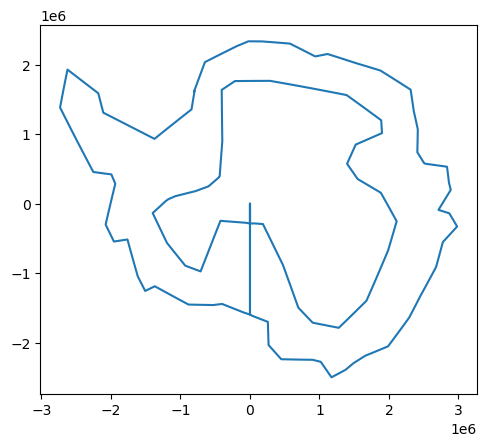

In [18]:
# CS2 graphical mode mask in versions 3.6 and later of the original kml have line to pole
gdfs['gdf_3.6'].boundary.plot()
plt.show()

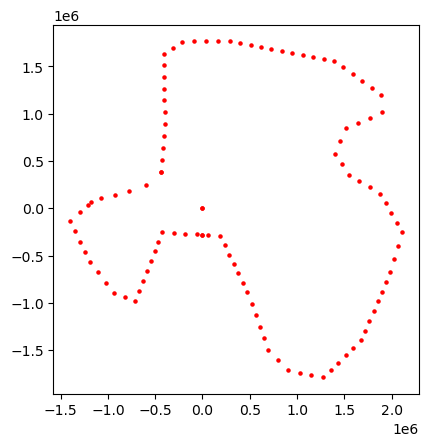

In [19]:
# Investigate aberrant line to near pole
# Extract vertices of polygons
points_list = []

for polygon in gdfs['gdf_3.6'][gdfs['gdf_3.6']['description'] == 'LRM over Antarctica ice sheet'].geometry:
    if polygon.geom_type == 'Polygon':
        exterior_coords = polygon.exterior.coords
        points_list.extend([Point(c) for c in exterior_coords])
    elif polygon.geom_type == 'MultiPolygon':
        for part in polygon:
            exterior_coords = part.exterior.coords
            points_list.extend([Point(c) for c in exterior_coords])

# Create a new GeoDataFrame with these points
points_gdf = gpd.GeoDataFrame(geometry=points_list)

# Plot points
fig, ax = plt.subplots()
points_gdf.plot(ax=ax, marker='o', color='red', markersize=5)
plt.show()

# Delete temp gdf
del points_gdf

In [20]:
# Create functions to remove point closest to the a specified of a polygon
def remove_closest_point_to_centroid(polygon):
    # Calculate the centroid of the polygon
    point_of_interest = Point(0,0)
    # Extract the points (coordinates) of the polygon's exterior
    coords = list(polygon.exterior.coords)
    
    # Find the index of the point closest to the centroid
    closest_point_index = np.argmin([Point(c).distance(point_of_interest) for c in coords[:-1]]) # Exclude the last point because it's the same as the first
    
    # Remove the closest point
    new_coords = [coords[i] for i in range(len(coords)-1) if i != closest_point_index] # Exclude the last repeating point for accurate removal
    
    # Create a new polygon from the remaining points
    new_polygon = Polygon(new_coords)
    
    return new_polygon

In [21]:
# Apply the function to each polygon in the GeoDataFrame
# gdfs['gdf_3.6']['geometry'] = gdfs['gdf_3.6']['geometry'].apply(remove_closest_point_to_centroid)
gdfs['gdf_3.6']['modified_geometry'] = gdfs['gdf_3.6']['geometry'].apply(remove_closest_point_to_centroid)

# If you want to replace the original geometry with the modified one
gdfs['gdf_3.6']['geometry'] = gdfs['gdf_3.6']['modified_geometry']
del gdfs['gdf_3.6']['modified_geometry']

# # Seems you need to run twice to work on all polygons
# Apply the function to each polygon in the GeoDataFrame
gdfs['gdf_3.6']['modified_geometry'] = gdfs['gdf_3.6']['geometry'].apply(remove_closest_point_to_centroid)

# If you want to replace the original geometry with the modified one
gdfs['gdf_3.6']['geometry'] = gdfs['gdf_3.6']['modified_geometry']
del gdfs['gdf_3.6']['modified_geometry']

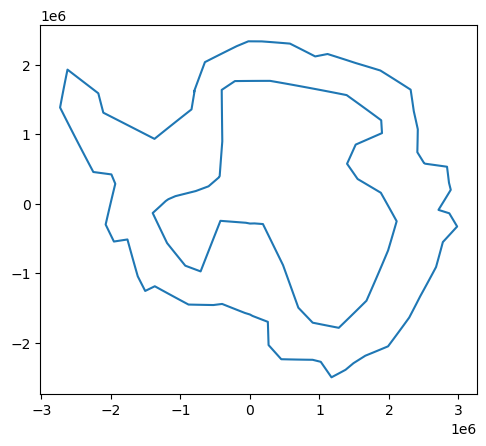

In [22]:
gdfs['gdf_3.6'].boundary.plot()
plt.show()

In [23]:
# Now to find the area difference between the two boundaries for plotting purposes
gdf_SARIn_3_1 = gdfs['gdf_3.1'][gdfs['gdf_3.1']['description'] == 'SARIn in Antarctica']
gdf_LRM_3_1 = gdfs['gdf_3.1'][gdfs['gdf_3.1']['description'] == 'LRM over Antarctica ice sheet']
gdf_SARIn_3_6 = gdfs['gdf_3.6'][gdfs['gdf_3.6']['description'] == 'SARIn in Antarctica']
gdf_LRM_3_6 = gdfs['gdf_3.6'][gdfs['gdf_3.6']['description'] == 'LRM over Antarctica ice sheet']

# Calculate the difference (area between the circles)
difference_area_3_1 = gdf_SARIn_3_1['geometry'].iloc[0].difference(gdf_LRM_3_1['geometry'].iloc[0])
difference_area_3_6 = gdf_SARIn_3_6['geometry'].iloc[0].difference(gdf_LRM_3_6['geometry'].iloc[0])

# Compute the symmetric difference of the two SARIn masks to show area that SARIn mode increased
symmetric_diff = difference_area_3_1.symmetric_difference(difference_area_3_6)

# Delete variables no longer needed
del gdf_LRM_3_1 
del gdf_LRM_3_6

# Create a new GeoDataFrame with the difference area
gdf_SARIn_3_1 = gpd.GeoDataFrame([{'geometry': difference_area_3_1}], crs='EPSG:3031')
gdf_SARIn_3_6 = gpd.GeoDataFrame([{'geometry': difference_area_3_6}], crs='EPSG:3031')

# Create a new GeoDataFrame with the symmetric difference
gdf_SARIn_3_1_3_6_diff = gpd.GeoDataFrame([{'geometry': symmetric_diff}], crs='EPSG:3031')

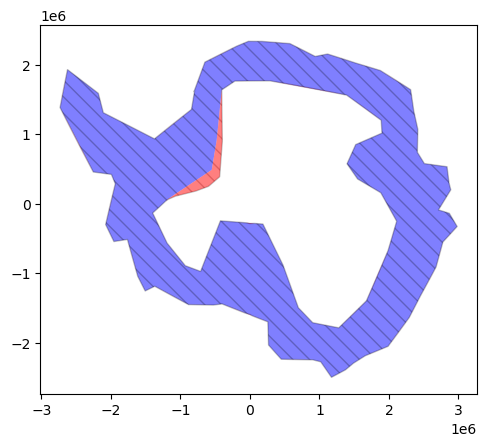

In [24]:
# Plot to ensure worked
fix, ax = plt.subplots()
gdf_SARIn_3_1.plot(ax=ax, alpha=0.5, color='blue')
gdf_SARIn_3_6.plot(ax=ax, alpha=0.25, facecolor='none', edgecolor='k', hatch=r'\\')
gdf_SARIn_3_1_3_6_diff.plot(ax=ax, alpha=0.5, color='red')
plt.show()

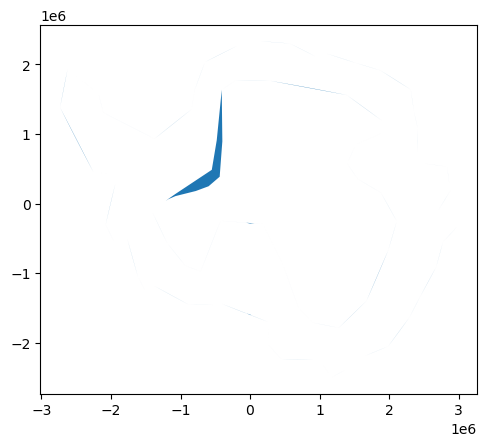

In [25]:
# Difference of two mode masks has many small polygons 
gdf_SARIn_3_1_3_6_diff.plot()
plt.show()

In [26]:
# Let's remove those to get a cleaner looking plot
# Define function to do the job
def keep_largest_polygon(geometry):
    if isinstance(geometry, MultiPolygon):
        # Use the .geoms attribute to explicitly iterate over polygons in a MultiPolygon
        largest_polygon = max(geometry.geoms, key=lambda p: p.area)
        return largest_polygon
    else:
        # If the geometry is not a MultiPolygon, just return it as is
        return geometry

# Apply the function to each geometry in the GeoDataFrame
gdf_SARIn_3_1_3_6_diff['geometry'] = gdf_SARIn_3_1_3_6_diff['geometry'].apply(keep_largest_polygon)

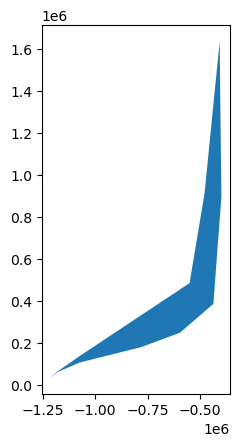

In [27]:
gdf_SARIn_3_1_3_6_diff.plot()
plt.show()

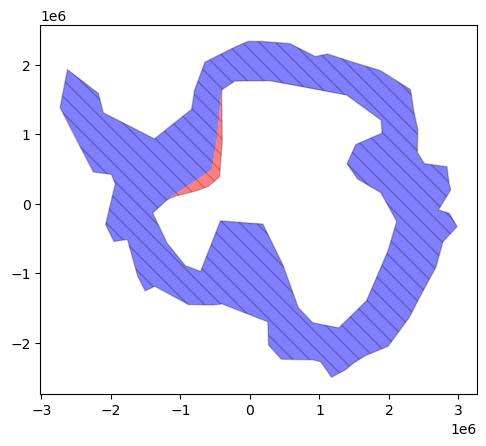

In [28]:
# Plot to ensure worked
fix, ax = plt.subplots()
gdf_SARIn_3_1.plot(ax=ax, alpha=0.5, color='blue')
gdf_SARIn_3_6.plot(ax=ax, alpha=0.25, facecolor='none', edgecolor='k', hatch=r'\\')
gdf_SARIn_3_1_3_6_diff.plot(ax=ax, alpha=0.5, color='red')
plt.show()

In [29]:
# Export the geodataframes to use in Fig. 1
gdf_SARIn_3_1.to_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1.geojson', driver='GeoJSON')
gdf_SARIn_3_1_3_6_diff.to_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1_3_6_diff.geojson', driver='GeoJSON')
gdf_SARIn_3_6.to_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_6.geojson', driver='GeoJSON')

# Export pre-processed CS2 data to netcdf

In [ ]:
CS2_Smith2017_subset.to_netcdf(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2018.75_relative_to_ATL14_v4.nc')

In [ ]:
# Ensure data import of exported netcdf works properly
# Import Smith and others, 2017, TC method CryoSat-2 SARIn height and dheight data (closed source aquired from Ben Smith)
CS2_Smith2017 = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2018.75_relative_to_ATL14_v4.nc')
CS2_Smith2017

In [35]:
# FIXME: temporary while v4 unavailable
CS2_Smith2017_subset.to_netcdf(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2019.0_relative_to_ATL14_v3.nc')

NameError: name 'CS2_Smith2017_subset' is not defined

In [ ]:
CS2_Smith2017_subset.to_netcdf(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2019.0_relative_to_ATL14_v4.nc')

In [ ]:
# Ensure data import of exported netcdf works properly
# Import Smith and others, 2017, TC method CryoSat-2 SARIn height and dheight data (closed source aquired from Ben Smith)
CS2_Smith2017 = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2019.0_relative_to_ATL14_v4.nc')
CS2_Smith2017